<a href="https://colab.research.google.com/github/mleticiamn/ClassificationProject-Jamming/blob/main/KNN_Jamming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import time
from collections import Counter

## KNN Class

In [ ]:
# KNN implementation
class KNN:
  def __init__(self, k):
    self.k = k

  # Dados de treinamento
  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def euclidean(self, x):
    return [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]

  # Dado de teste
  def predict(self, X):
    predictions = [self._predict(x) for x in X]
    return np.array(predictions)

  def _predict(self, x):
    distances =  self.euclidean(x)
    sorted_indices = np.argsort(distances) # Returns the >indices< that would sort an array
    k_indices = sorted_indices[:self.k]
    k_nearest_labels = []
    for i in k_indices:
      k_nearest_labels.append(self.y_train[i])
    most_common = Counter(k_nearest_labels).most_common(1) # Retorna uma lista contendo a tupla (classe, contagem)
    return most_common[0][0]

  def score(self, X_test, y_test):
    y_pred = self.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy

## Evaluation Metrics Functions

In [ ]:
def accuracy(preds, y_test):
  return 100 * (preds == y_test).mean()

In [ ]:
def confusion_matrix(real, prediction):
  confusion_matrix = metrics.confusion_matrix(real, prediction)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                              display_labels=["1", "2", "3"])

  plt.figure(figsize=(6,6))
  cm_display.plot(cmap='gist_earth_r')
  plt.ylabel('True label', fontsize=15)
  plt.xlabel('Predicted label', fontsize=15)

  plt.gca().xaxis.set_tick_params(labelsize=18)
  plt.gca().yaxis.set_tick_params(labelsize=18)

  for text in cm_display.ax_.texts:
      text.set_fontsize(21)

  plt.show()

  return confusion_matrix

In [ ]:
def precision(true_pos, false_pos):
  return (np.sum(true_pos / (true_pos + false_pos)) / len(true_pos))*100

In [ ]:
def recall(true_pos, false_neg):
  return (np.sum(true_pos / (true_pos + false_neg)) / len(true_pos))*100

In [ ]:
def f1_score(precision, recall):
  return (2*precision*recall)/(precision+recall)

# Dataset 1 non-normalized

In [ ]:
dataset = pd.read_csv('RF_Jamming_Dataset_1.csv')
dataset = dataset.rename(columns={'Relative_Speed': 'RS'})
dataset = dataset.drop('Speed', axis=1)
dataset.head()

,Time,SNR,RSSI,PDR,RS,Scenario
0,0.1,22.35,-48.38,1.000000,25.313981,2
1,0.2,21.62,-49.14,0.999999,25.421060,2
2,0.3,20.85,-49.92,0.999997,25.327275,2
3,0.4,20.07,-50.69,0.999989,25.256933,2
4,0.5,19.30,-51.46,0.999958,25.038900,2


In [ ]:
# Pearson correlation coefficient
print('Correlations betweeen Scenario and:')
for feature in dataset.columns[1:6]:
  correlation = dataset['Scenario'].corr(dataset[feature])
  print(f'{feature}: {correlation}')

Correlations betweeen Scenario and:
SNR: -0.11075826004501302
RSSI: -0.27000418937173976
PDR: -0.4030059677681682
RS: -0.6711845414364626
Scenario: 0.9999999999999999


<Axes: >

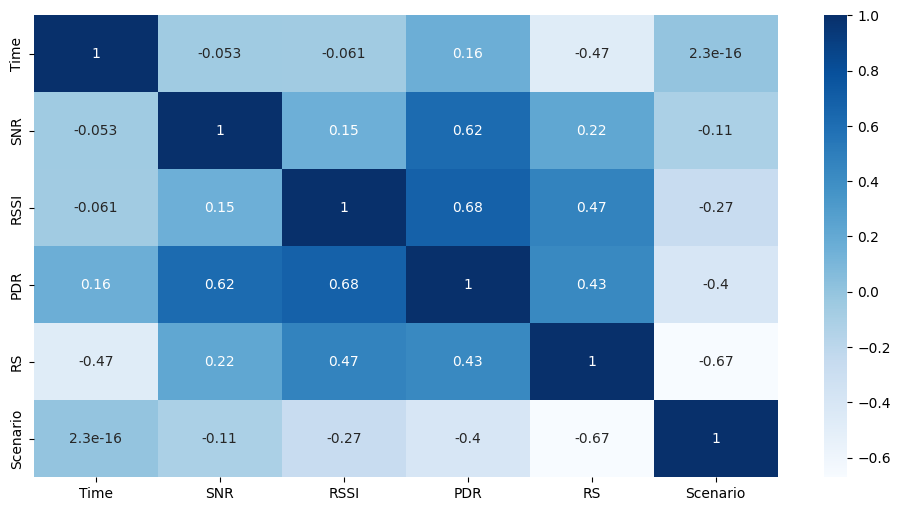

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap='Blues')

In [ ]:
# Dividing our dataset into features and targets
data_targets = dataset['Scenario']
data_features = dataset.drop('Scenario', axis=1)

In [ ]:
# Split data
# 70% of our data used for testing
X_train, X_test, y_train, y_test = train_test_split(data_features, data_targets, test_size=0.7, random_state=42)

In [ ]:
def elbow_curve_validation(KNN, X_train, y_train, max_k):
  k_values = range(1, max_k + 1)
  scores = []
  times = []

  for k in k_values:
    start_time = time.time()
    classifier = KNN(k)
    classifier.fit(X_train.values, y_train.values)
    end_time = time.time()
    training_time = end_time - start_time
    score = classifier.score(X_train.values, y_train.values)
    scores.append(score)
    times.append(training_time)

  plt.figure(figsize=(10, 6))
  plt.plot(k_values, scores, marker='o', linestyle='-')
  plt.xlabel('Number of Neighbors (k)')
  plt.ylabel('Accuracy Score')
  plt.xticks(k_values)
  plt.grid(True)
  plt.show()

In [ ]:
# Apply the KNN
classifier = KNN(k=5)
classifier.fit(X_train.values, y_train.values)
start_time = time.time()
preds = classifier.predict(X_test.values)
inference_time = (time.time() - start_time)/len(X_test)

<Figure size 600x600 with 0 Axes>

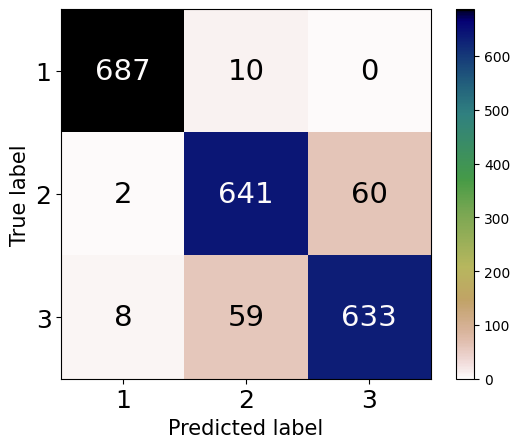

In [ ]:
cm = confusion_matrix(y_test.values, preds)

In [ ]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos

In [ ]:
print(f'Tempo de inferência do KNN manual: {inference_time}')

Tempo de inferência do KNN manual: 0.006721633615947905


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier2 = KNeighborsClassifier(5)
classifier2.fit(X_train.values, y_train.values)
start_time2 = time.time()
preds2 = classifier2.predict(X_test.values)
inference_time2 = (time.time() - start_time2)/len(X_test)
print(f'Tempo de inferência do KNN importado: {inference_time2}')


Tempo de inferência do KNN importado: 6.32710683913458e-05


In [ ]:
print('KNN manual')
print(f'Accuracy: {accuracy(preds, y_test.values)}%')
precision_scr = precision(true_pos, false_pos)
print(f'Precision: {precision_scr}%')
recall_scr = recall(true_pos, false_neg)
print(f'Recall: {recall_scr}%')
print(f'F1-Score: {f1_score(precision_scr,recall_scr)}')

KNN manual
Accuracy: 93.38095238095238%
Precision: 93.3963204177604%
Recall: 93.39150184585509%
F1-Score: 93.3939110696553


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier2, data_features, data_targets, cv=5)
print("Average cross-validation score:", scores.mean())

Average cross-validation score: 0.7873333333333333


In [ ]:
n_iterations = 30
inference_times = []

for _ in range(n_iterations):
    start_time = time.time()
    preds = classifier2.predict(X_test.values)
    inference_time = time.time() - start_time
    inference_times.append(inference_time/len(X_test))

average_inference_time = np.mean(inference_times)

print(f"Tempo médio de inferência por previsão: {average_inference_time} segundos")

Tempo médio de inferência por previsão: 6.0495505257258344e-05 segundos


# Feature Importance

In [ ]:
# data = {'Time':[0], 'SNR':[0], 'Speed':[0], 'RSSI':[0], 'PDR':[0], 'RS':[0]}
# feat_imp = pd.DataFrame(data)
# feat_imp

In [ ]:
# X_test.head()

In [ ]:
# valid_time = X_test.copy()
# valid_time['Time'] = np.random.permutation(valid_time['Time'])
# valid_time.head()

In [ ]:
# preds_disposable = classifier2.predict(valid_time.values)
# acc_time = accuracy(preds_disposable, y_test)
# feat_imp['Time'] = acc_time
# print(acc_time)

In [ ]:
# valid_snr = X_test.copy()
# valid_snr['SNR'] = np.random.permutation(valid_snr['SNR'])
# valid_snr.head()

In [ ]:
# preds_disposable = classifier2.predict(valid_snr.values)
# acc_snr = accuracy(preds_disposable, y_test)
# feat_imp['SNR'] = acc_snr
# print(acc_snr)

In [ ]:
# valid_speed = X_test.copy()
# valid_speed['Speed'] = np.random.permutation(valid_speed['Speed'])
# valid_speed.head()

In [ ]:
# preds_disposable = classifier2.predict(valid_speed.values)
# acc_speed = accuracy(preds_disposable, y_test)
# feat_imp['Speed'] = acc_speed
# print(acc_speed)

In [ ]:
# valid_rssi = X_test.copy()
# valid_rssi['RSSI'] = np.random.permutation(valid_rssi['RSSI'])
# valid_rssi.head()

In [ ]:
# preds_disposable = classifier2.predict(valid_rssi.values)
# acc_rssi = accuracy(preds_disposable, y_test)
# feat_imp['RSSI'] = acc_rssi
# print(acc_rssi)

In [ ]:
# valid_pdr = X_test.copy()
# valid_pdr['PDR'] = np.random.permutation(valid_pdr['PDR'])
# valid_pdr.head()

In [ ]:
# preds_disposable = classifier2.predict(valid_pdr.values)
# acc_pdr = accuracy(preds_disposable, y_test)
# feat_imp['PDR'] = acc_pdr
# print(acc_pdr)

In [ ]:
# valid_rs = X_test.copy()
# valid_rs['RS'] = np.random.permutation(valid_rs['RS'])
# valid_rs.head()

In [ ]:
# preds_disposable = classifier2.predict(valid_rs.values)
# acc_rs = accuracy(preds_disposable, y_test)
# feat_imp['RS'] = acc_rs
# print(acc_rs)

In [ ]:
# feat_imp

# Dataset 1 normalized

In [ ]:
from sklearn.preprocessing import StandardScaler

# Inicializar o scaler
scaler = StandardScaler()

# Normalizar os dados de treinamento e teste
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
# Aplicar o KNN aos dados normalizados
classifier_normalized = KNN(k=3)
classifier_normalized.fit(X_train_normalized, y_train.values)

In [ ]:
# Realizar a predição nos dados de teste normalizados
inference_start_time = time.time()
preds_normalized = classifier_normalized.predict(X_test_normalized)
inference_time_normalized = (time.time() - inference_start_time)

<Figure size 600x600 with 0 Axes>

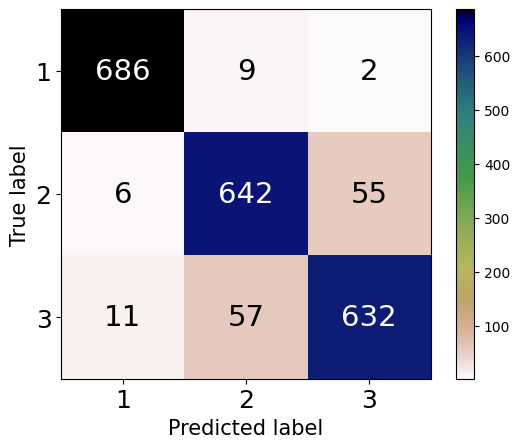

Accuracy com dados normalizados: 93.33333333333333%
Tempo de inferência com dados normalizados: 12.824964761734009
Precision com dados normalizados: 93.32896640135796
Recall com dados normalizados: 93.34347462747373
F1-Score com dados normalizados: 93.33621995062447


In [ ]:
# Avaliar o modelo nos dados de teste normalizados
accuracy_normalized = accuracy(preds_normalized, y_test.values)
cm_normalized = confusion_matrix(y_test.values, preds_normalized)
true_pos_normalized = np.diag(cm_normalized)
false_pos_normalized = np.sum(cm_normalized, axis=0) - true_pos_normalized
false_neg_normalized = np.sum(cm_normalized, axis=1) - true_pos_normalized

# Exibir os resultados
print(f'Accuracy com dados normalizados: {accuracy_normalized}%')
print(f'Tempo de inferência com dados normalizados: {inference_time_normalized}')
print(f'Precision com dados normalizados: {precision(true_pos_normalized, false_pos_normalized)}')
print(f'Recall com dados normalizados: {recall(true_pos_normalized, false_neg_normalized)}')
print(f'F1-Score com dados normalizados: {f1_score(precision(true_pos_normalized, false_pos_normalized), recall(true_pos_normalized, false_neg_normalized))}')

In [ ]:
# Just so we can get the inference time with the sklearn classifier
from sklearn.neighbors import KNeighborsClassifier

inference_start_time = time.time()
classifier2 = KNeighborsClassifier(3)
classifier2.fit(X_train_normalized, y_train.values)
preds2 = classifier2.predict(X_test_normalized)
inference_time = (time.time() - inference_start_time)
print(f'Tempo de inferência do KNN importado: {inference_time}')

Tempo de inferência do KNN importado: 0.09578514099121094
